In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 540

nband = 80

nv = 200

dv = 0.005

tsfc =294

ng =9

nref =3

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

ng_refs = (/ 3 , 2 , 4 /) 

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.9 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.6 , 1.6,
     &     1.9/

klin =6.375563e-24

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

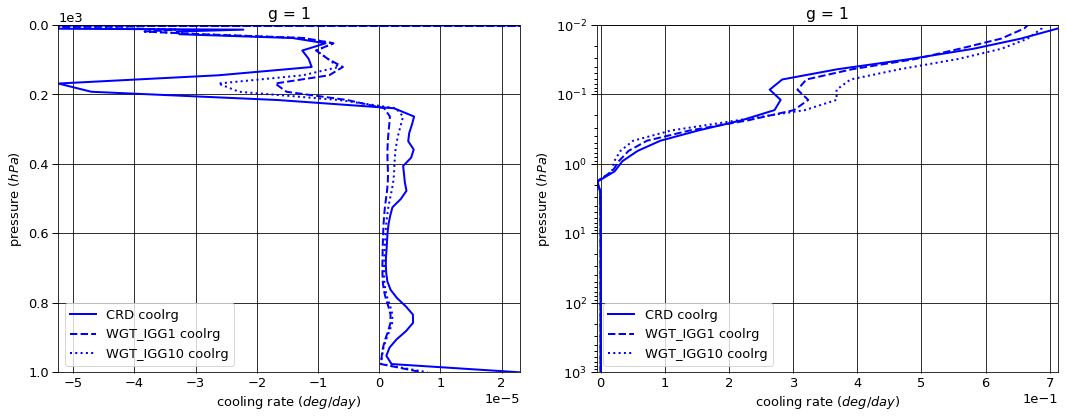

# Figure: cooling rate g-group 2

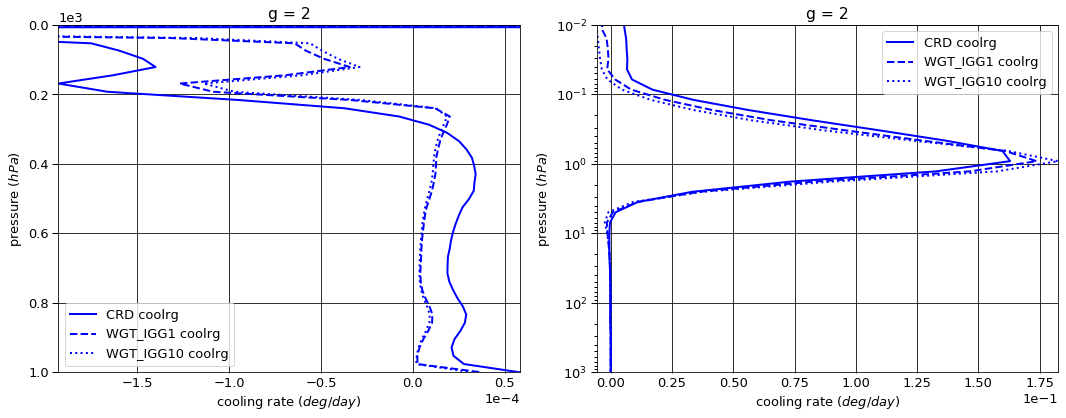

# Figure: cooling rate g-group 3

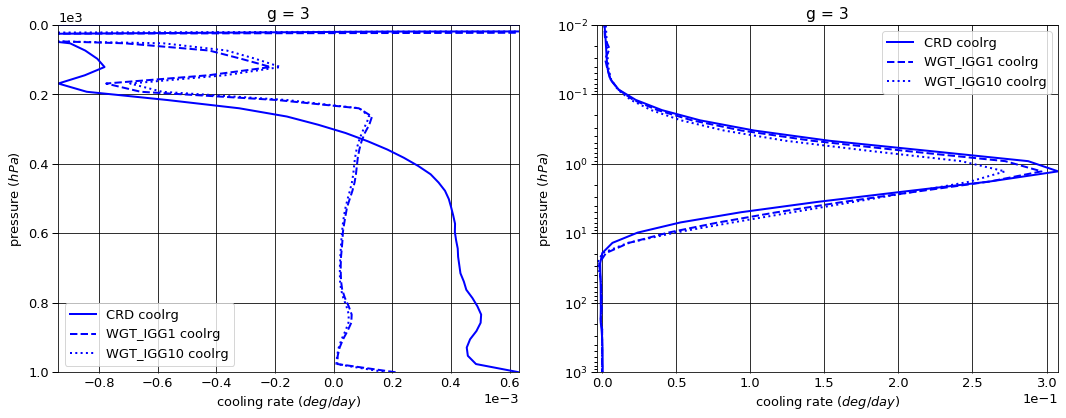

# Figure: cooling rate g-group 4

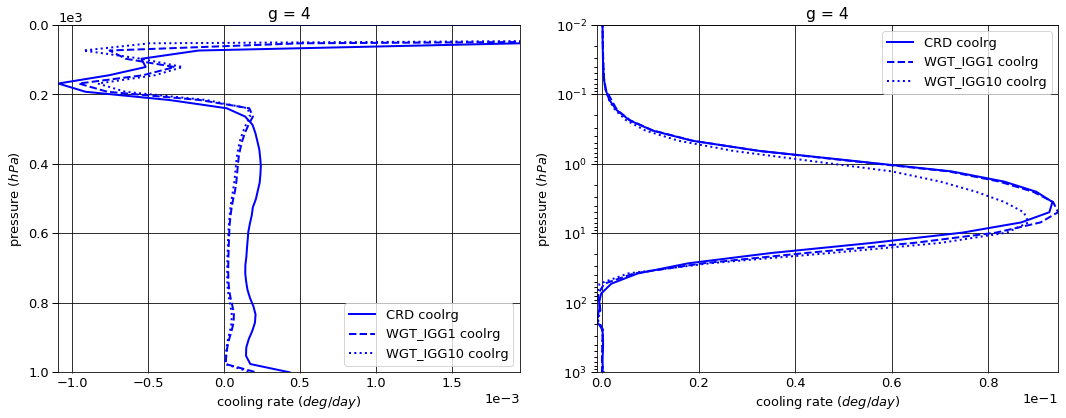

# Figure: cooling rate g-group 5

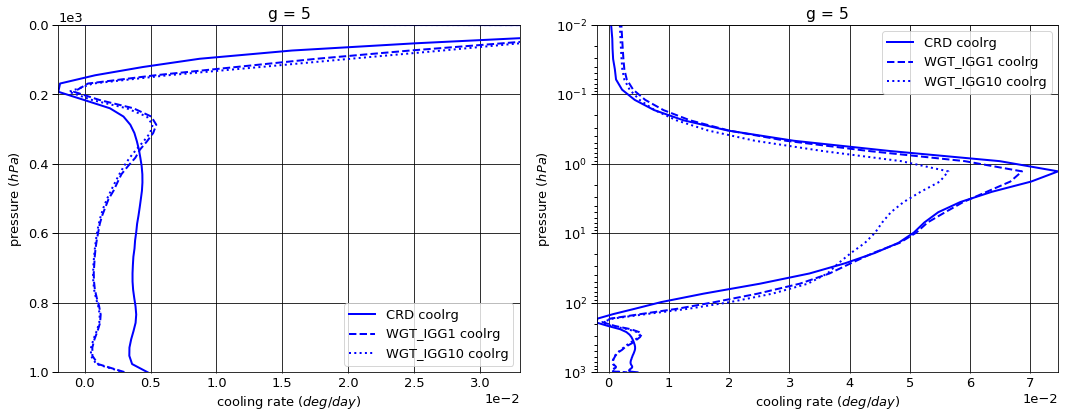

# Figure: cooling rate g-group 6

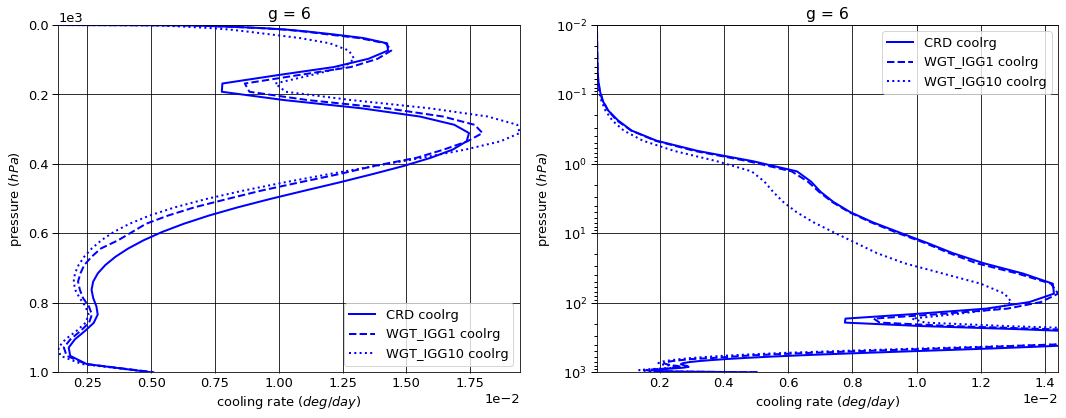

# Figure: cooling rate g-group 7

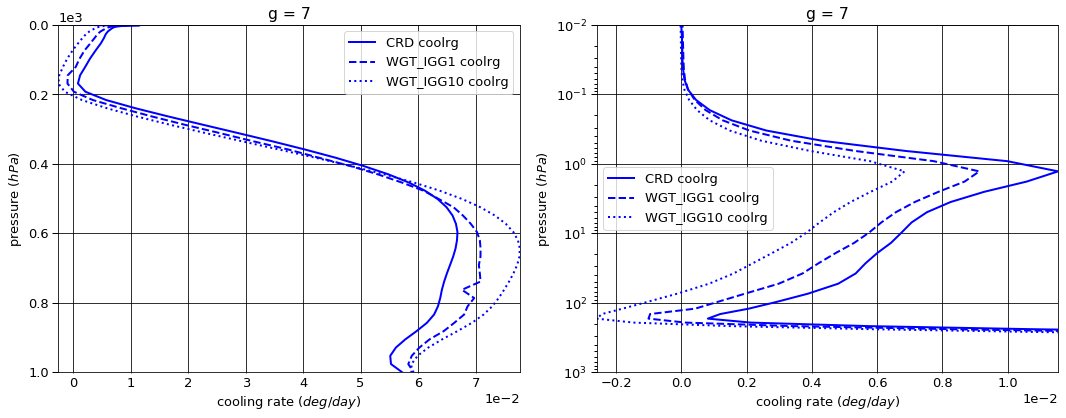

# Figure: cooling rate g-group 8

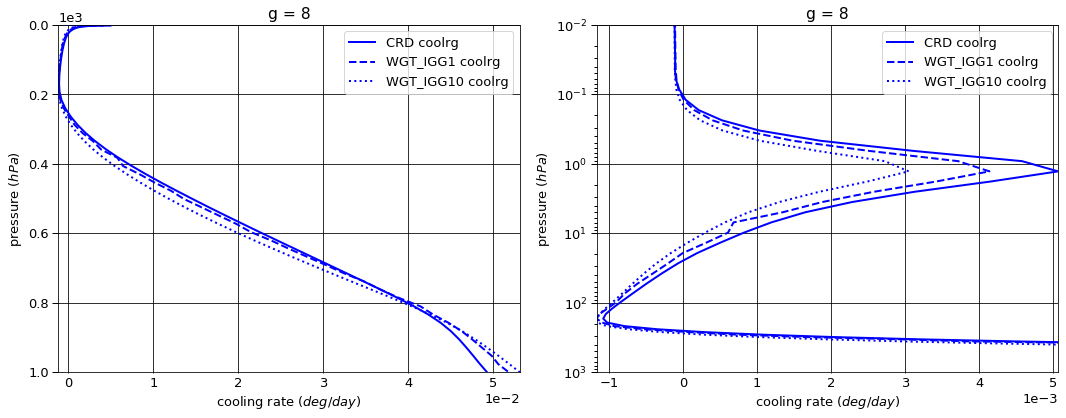

# Figure: cooling rate g-group 9

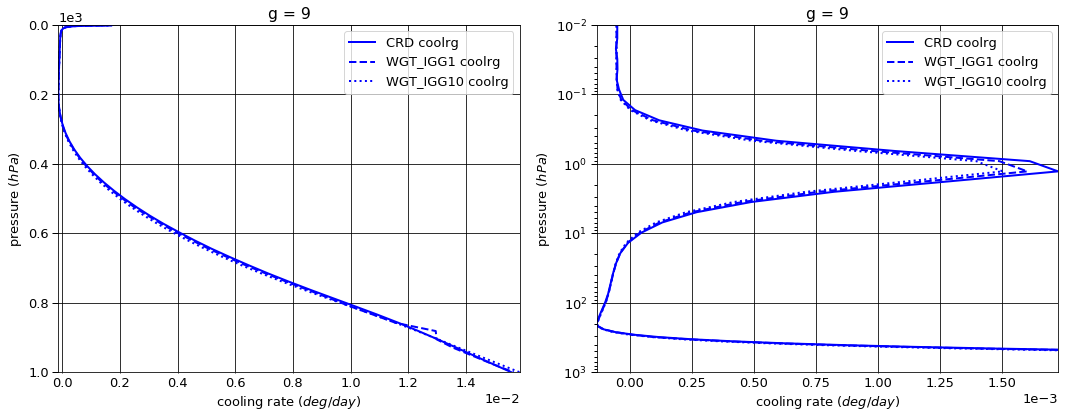

# Figure: cooling rate g-group total

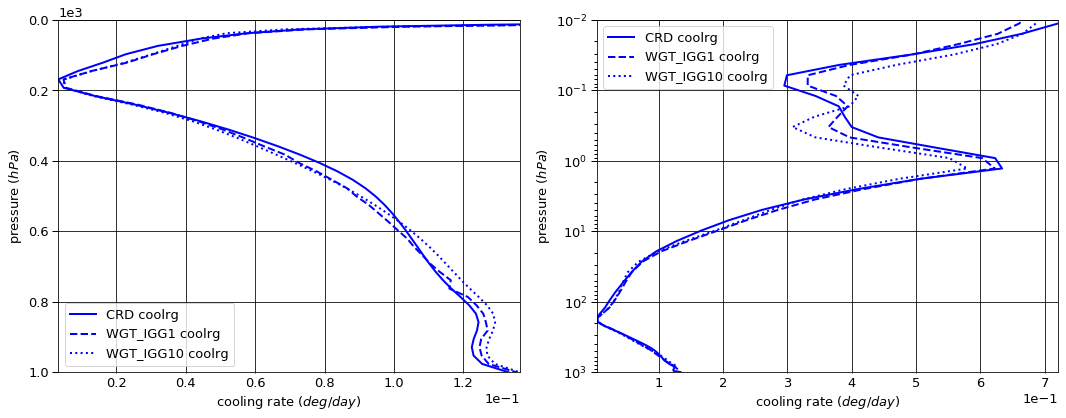

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.016856  0.000000  -0.016856
  1013.0   76     -0.040651  0.040582  -0.000069
2 0.0      1      -0.030236  0.000000  -0.030236
  1013.0   76     -0.045180  0.044809  -0.000371
3 0.0      1      -0.168347  0.000000  -0.168347
  1013.0   76     -0.280379  0.266502  -0.013877
4 0.0      1      -0.206613  0.000000  -0.206613
  1013.0   76     -0.442773  0.439396  -0.003377
5 0.0      1      -0.829080  0.000000  -0.829080
  1013.0   76     -1.770965  1.646498  -0.124467
6 0.0      1      -1.036947  0.000000  -1.036947
  1013.0   76     -2.421473  2.396895  -0.024579
7 0.0      1      -6.470606  0.000000  -6.470606
  1013.0   76     -9.613014  8.317298  -1.295717
8 0.0      1      -7.532720  0.000000  -7.532720
  1013.0   76     -8.220159  2.962024  -5.258135
9 0.0      1     -13.292082  0.000000 -13.292082
  1013.0   76    -13.400813  0.651190 -12.749622


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.016306  0.000000  -0.016306
  1013.0   76     -0.040651  0.040632  -0.000019
2 0.0      1      -0.030999  0.000000  -0.030999
  1013.0   76     -0.045180  0.045075  -0.000105
3 0.0      1      -0.164339  0.000000  -0.164339
  1013.0   76     -0.280379  0.279781  -0.000598
4 0.0      1      -0.206771  0.000000  -0.206771
  1013.0   76     -0.442773  0.442186  -0.000588
5 0.0      1      -0.664202  0.000000  -0.664202
  1013.0   76     -1.770965  1.759314  -0.011651
6 0.0      1      -0.997200  0.000000  -0.997200
  1013.0   76     -2.421473  2.397958  -0.023516
7 0.0      1      -6.446159  0.000000  -6.446159
  1013.0   76     -9.613014  8.459380  -1.153634
8 0.0      1      -7.551178  0.000000  -7.551178
  1013.0   76     -8.220159  2.944709  -5.275450
9 0.0      1     -13.295272  0.000000 -13.295272
  1013.0   76    -13.400813  0.644016 -12.756797


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.015672  0.000000  -0.015672
  1013.0   76     -0.040651  0.040629  -0.000022
2 0.0      1      -0.031488  0.000000  -0.031488
  1013.0   76     -0.045180  0.045091  -0.000089
3 0.0      1      -0.164098  0.000000  -0.164098
  1013.0   76     -0.280379  0.279878  -0.000501
4 0.0      1      -0.205287  0.000000  -0.205287
  1013.0   76     -0.442773  0.442280  -0.000493
5 0.0      1      -0.652675  0.000000  -0.652675
  1013.0   76     -1.770965  1.760278  -0.010688
6 0.0      1      -0.985154  0.000000  -0.985154
  1013.0   76     -2.421473  2.399801  -0.021673
7 0.0      1      -6.471248  0.000000  -6.471248
  1013.0   76     -9.613014  8.624495  -0.988519
8 0.0      1      -7.619402  0.000000  -7.619402
  1013.0   76     -8.220159  2.789136  -5.431023
9 0.0      1     -13.298157  0.000000 -13.298157
  1013.0   76    -13.400813  0.635989 -12.764824


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.496660e-04  0.000000  0.000550
  1013.0   76     0.000000e+00  0.000050  0.000050
2 0.0      1     -7.633780e-04  0.000000 -0.000763
  1013.0   76     6.938894e-18  0.000266  0.000266
3 0.0      1      4.007720e-03  0.000000  0.004008
  1013.0   76     0.000000e+00  0.013279  0.013279
4 0.0      1     -1.581300e-04  0.000000 -0.000158
  1013.0   76     0.000000e+00  0.002789  0.002789
5 0.0      1      1.648779e-01  0.000000  0.164878
  1013.0   76     0.000000e+00  0.112816  0.112816
6 0.0      1      3.974699e-02  0.000000  0.039747
  1013.0   76    -4.440892e-16  0.001063  0.001063
7 0.0      1      2.444670e-02  0.000000  0.024447
  1013.0   76     1.776357e-15  0.142083  0.142083
8 0.0      1     -1.845800e-02  0.000000 -0.018458
  1013.0   76     0.000000e+00 -0.017315 -0.017315
9 0.0      1     -3.190000e-03  0.000000 -0.003190
  1013.0   76     1.776357e-15 -0.007174 -0.007175


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.183425e-03  0.000000  0.001183
  1013.0   76     0.000000e+00  0.000047  0.000047
2 0.0      1     -1.251968e-03  0.000000 -0.001252
  1013.0   76     6.938894e-18  0.000282  0.000282
3 0.0      1      4.248800e-03  0.000000  0.004249
  1013.0   76     0.000000e+00  0.013376  0.013376
4 0.0      1      1.325490e-03  0.000000  0.001325
  1013.0   76     0.000000e+00  0.002884  0.002884
5 0.0      1      1.764050e-01  0.000000  0.176405
  1013.0   76     0.000000e+00  0.113779  0.113779
6 0.0      1      5.179336e-02  0.000000  0.051793
  1013.0   76    -4.440892e-16  0.002906  0.002906
7 0.0      1     -6.428000e-04  0.000000 -0.000643
  1013.0   76     1.776357e-15  0.307198  0.307198
8 0.0      1     -8.668240e-02  0.000000 -0.086682
  1013.0   76     0.000000e+00 -0.172888 -0.172888
9 0.0      1     -6.075000e-03  0.000000 -0.006075
  1013.0   76     1.776357e-15 -0.015202 -0.015202

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.750485
  1001.112500 75     0.000023
2 0.000312    1     -0.001302
  1001.112500 75     0.000058
3 0.000312    1     -0.001143
  1001.112500 75     0.000633
4 0.000312    1      0.000044
  1001.112500 75     0.000433
5 0.000312    1     -0.000222
  1001.112500 75     0.004777
6 0.000312    1      0.000031
  1001.112500 75     0.005001
7 0.000312    1     -0.000044
  1001.112500 75     0.057236
8 0.000312    1     -0.000383
  1001.112500 75     0.049294
9 0.000312    1     -0.000048
  1001.112500 75     0.015578


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.626678
  1001.112500 75     0.000007
2 0.000312    1     -0.007266
  1001.112500 75     0.000037
3 0.000312    1     -0.001311
  1001.112500 75     0.000213
4 0.000312    1      0.000066
  1001.112500 75     0.000213
5 0.000312    1      0.001472
  1001.112500 75     0.003068
6 0.000312    1      0.000033
  1001.112500 75     0.005116
7 0.000312    1     -0.000010
  1001.112500 75     0.059226
8 0.000312    1     -0.000113
  1001.112500 75     0.051851
9 0.000312    1     -0.000050
  1001.112500 75     0.015652


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.581922
  1001.112500 75     0.000008
2 0.000312    1     -0.009521
  1001.112500 75     0.000032
3 0.000312    1      0.000165
  1001.112500 75     0.000180
4 0.000312    1      0.000078
  1001.112500 75     0.000178
5 0.000312    1      0.001322
  1001.112500 75     0.002985
6 0.000312    1      0.000025
  1001.112500 75     0.005059
7 0.000312    1     -0.000053
  1001.112500 75     0.058828
8 0.000312    1     -0.000114
  1001.112500 75     0.053146
9 0.000312    1     -0.000049
  1001.112500 75     0.015866


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.123807
  1001.112500 75    -0.000016
2 0.000312    1     -0.005963
  1001.112500 75    -0.000021
3 0.000312    1     -0.000168
  1001.112500 75    -0.000420
4 0.000312    1      0.000022
  1001.112500 75    -0.000220
5 0.000312    1      0.001694
  1001.112500 75    -0.001709
6 0.000312    1      0.000002
  1001.112500 75     0.000115
7 0.000312    1      0.000034
  1001.112500 75     0.001990
8 0.000312    1      0.000270
  1001.112500 75     0.002557
9 0.000312    1     -0.000002
  1001.112500 75     0.000074


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.168562
  1001.112500 75    -0.000015
2 0.000312    1     -0.008219
  1001.112500 75    -0.000026
3 0.000312    1      0.001307
  1001.112500 75    -0.000453
4 0.000312    1      0.000033
  1001.112500 75    -0.000254
5 0.000312    1      0.001544
  1001.112500 75    -0.001792
6 0.000312    1     -0.000006
  1001.112500 75     0.000058
7 0.000312    1     -0.000009
  1001.112500 75     0.001592
8 0.000312    1      0.000269
  1001.112500 75     0.003852
9 0.000312    1     -0.000001
  1001.112500 75     0.000288

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.583485,0.000000,-29.583485
1013.0,76,-36.235408,16.765194,-19.470213



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.372425,0.000000,-29.372425
1013.0,76,-36.235408,17.013051,-19.222358



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.443181,0.000000,-29.443181
1013.0,76,-36.235408,17.017577,-19.217831



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.110594e-01,0.000000,0.211059
1013.0,76,7.105427e-15,0.247856,0.247855



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.403039e-01,0.000000,0.140304
1013.0,76,7.105427e-15,0.252383,0.252382


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.747417
1001.112500,75,0.133033



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.619499
1001.112500,75,0.135383



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.573774
1001.112500,75,0.136281



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.127918
1001.112500,75,0.002350



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.173643
1001.112500,75,0.003249


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001094
2,0.001250,0.001218
3,0.007750,0.007589
4,0.012250,0.011931
5,0.048938,0.048008
6,0.066937,0.065427
7,0.265437,0.261001
8,0.226562,0.227542
9,0.369750,0.376189


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.213044e-19
2,2.053870e-20
3,1.906144e-21
4,1.715202e-21
5,1.602800e-22
6,6.938182e-22
7,6.651099e-23
8,6.375895e-24
9,1.011442e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.213044e-19,NaN,0.001125,0.001094,0.001125,0.001094,1.0
2,2.053870e-20,0.092807,0.001250,0.001218,0.002375,0.002312,1.0
3,1.906144e-21,0.092807,0.007750,0.007589,0.010125,0.009900,1.0
4,1.715202e-21,0.899828,0.012250,0.011931,0.022375,0.021832,10.0
5,1.602800e-22,0.093447,0.048938,0.048008,0.071313,0.069840,10.0
6,6.938182e-22,4.328789,0.066937,0.065427,0.138250,0.135267,500.0
7,6.651099e-23,0.095862,0.265437,0.261001,0.403687,0.396268,500.0
8,6.375895e-24,0.095862,0.226562,0.227542,0.630250,0.623811,500.0
9,1.011442e-25,0.015864,0.369750,0.376189,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     6.071634e-19  3.839070e-19   1.581538  2.859465e-03
      2 0.000312     2.200693e-20  1.378525e-20   1.596411  8.602830e-05
      3 0.000312     1.454811e-21  8.020462e-22   1.813875  6.664393e-06
      4 0.000312     1.315177e-23  1.201818e-23   1.094323  6.781843e-08
      5 0.000312     3.766649e-23  1.657918e-23   2.271916  1.547367e-07
      6 0.000312     5.026019e-25  4.909700e-25   1.023692  2.623568e-09
      7 0.000312     7.266072e-25  4.900621e-25   1.482684  3.220207e-09
      8 0.000312     4.638344e-25  1.176975e-25   3.940903  2.088844e-09
      9 0.000312     8.115172e-26  4.129425e-27  19.652060  4.091891e-10
2     1 0.000750     6.099959e-19  3.855300e-19   1.582227  1.157020e-03
      2 0.000750     2.215596e-20  1.386419e-20   1.598071  3.486420e-05
      3 0.000750     1.465669e-21  8.071407e-22   1.815879  2.703793e-06
      4 0.000750     1.340814e-23  1.225732e-23   1.093889  2.785196e-08
      5 0.000750     3.793526e-23  1.666706e-23   2.276061  6.274466e-08
      6 0.000750     5.079769e-25  4.962006e-25   1.023733  1.068014e-09
      7 0.000750     7.328287e-25  4.937197e-25   1.484301  1.307588e-09
      8 0.000750     4.684790e-25  1.184512e-25   3.955036  8.496022e-10
      9 0.000750     8.215161e-26  4.153473e-27  19.779018  1.668438e-10
3     1 0.001052     6.160734e-19  3.889883e-19   1.583784  1.638411e-03
      2 0.001052     2.247114e-20  1.402806e-20   1.601870  4.951877e-05
      3 0.001052     1.488294e-21  8.169930e-22   1.821673  3.847954e-06
      4 0.001052     1.377510e-23  1.258654e-23   1.094431  4.012256e-08
      5 0.001052     3.849929e-23  1.683975e-23   2.286214  8.921065e-08
      6 0.001052     5.178521e-25  5.057599e-25   1.023909  1.526729e-09
      7 0.001052     7.458722e-25  5.012045e-25   1.488160  1.864433e-09
      8 0.001052     4.784249e-25  1.199752e-25   3.987698  1.216173e-09
      9 0.001052     8.431341e-26  4.201872e-27  20.065676  2.401274e-10
4     1 0.001476     6.225417e-19  3.926759e-19   1.585383  2.322148e-03
      2 0.001476     2.280964e-20  1.420388e-20   1.605873  7.041174e-05
      3 0.001476     1.512707e-21  8.276699e-22   1.827670  5.483384e-06
      4 0.001476     1.420261e-23  1.297284e-23   1.094796  5.802906e-08
      5 0.001476     3.910771e-23  1.702641e-23   2.296885  1.269974e-07
      6 0.001476     5.288256e-25  5.163872e-25   1.024087  2.186995e-09
      7 0.001476     7.600035e-25  5.092970e-25   1.492260  2.662210e-09
      8 0.001476     4.891926e-25  1.216165e-25   4.022419  1.743670e-09
      9 0.001476     8.666283e-26  4.254111e-27  20.371547  3.462462e-10
5     1 0.002070     6.290473e-19  3.963950e-19   1.586921  3.290372e-03
      2 0.002070     2.315391e-20  1.438281e-20   1.609832  1.001031e-04
      3 0.002070     1.537694e-21  8.387237e-22   1.833374  7.813342e-06
      4 0.002070     1.469093e-23  1.341861e-23   1.094818  8.418878e-08
      5 0.002070     3.972990e-23  1.721884e-23   2.307351  1.807742e-07
      6 0.002070     5.405360e-25  5.277385e-25   1.024250  3.135081e-09
      7 0.002070     7.745238e-25  5.176113e-25   1.496342  3.801156e-09
      8 0.002070     5.002283e-25  1.232982e-25   4.057060  2.499571e-09
      9 0.002070     8.907879e-26  4.307792e-27  20.678527  4.991598e-10
6     1 0.002904     6.355796e-19  4.001426e-19   1.588383  4.662545e-03
      2 0.002904     2.350415e-20  1.456527e-20   1.613711  1.423397e-04
      3 0.002904     1.563319e-21  8.502735e-22   1.838608  1.113670e-05
      4 0.002904     1.526255e-23  1.394636e-23   1.094375  1.227037e-07
      5 0.002904     4.036708e-23  1.741875e-23   2.317449  2.573939e-07
      6 0.002904     5.531904e-25  5.400208e-25   1.024387  4.500292e-09
      7 0.002904     7.894693e-25  5.261864e-25   1.500361  5.429083e-09
      8 0.002904     5.115361e-25  1.250305e-25   4.091290  3.583761e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
